# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys

sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
# conf.setMaster("local[*]")
conf.setAppName("spark_examples")
conf.set("spark.executor.memory", "2g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

conf.set("spark.executor.instances", "2")  # кол-во  executor'ов
conf.set("spark.executor.cores", "2")  # сколько ядер у каждого

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
!hdfs dfs -copyFromLocal /workspace/data/MovieLens/data .

copyFromLocal: `data/ml-25m/README.txt': File exists
copyFromLocal: `data/ml-25m/genome-scores.csv': File exists
copyFromLocal: `data/ml-25m/genome-tags.csv': File exists
copyFromLocal: `data/ml-25m/links.csv': File exists
copyFromLocal: `data/ml-25m/ml-25m-README.htm': File exists
copyFromLocal: `data/ml-25m/movies.csv': File exists
copyFromLocal: `data/ml-25m/ratings.csv': File exists
copyFromLocal: `data/ml-25m/tags.csv': File exists
copyFromLocal: `data/ml-25m/tmdb.json': File exists


In [5]:
!hdfs dfs -ls data/ml-25m/

Found 10 items
-rw-r--r--   1 root supergroup      10460 2021-02-08 14:13 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2021-02-08 14:13 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2021-02-08 14:14 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2021-02-08 14:14 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2021-02-08 14:14 data/ml-25m/ml-25m-README.htm
drwxr-xr-x   - root supergroup          0 2021-02-08 15:06 data/ml-25m/movie_avg_rating
-rw-r--r--   1 root supergroup    3038099 2021-02-08 14:14 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2021-02-08 14:14 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2021-02-08 14:14 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2021-02-08 14:14 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [6]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [7]:
ratings = sc.textFile(RATINGS_PATH)

In [8]:
%%time
ratings.take(5)

CPU times: user 5.66 ms, sys: 732 µs, total: 6.4 ms
Wall time: 1.18 s


['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
ratings.getNumPartitions()

5

In [10]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [11]:
ratings.count()

25000095

Количество пользователей

In [12]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 7.54 ms, sys: 3.37 ms, total: 10.9 ms
Wall time: 34.1 s


162541

Сохраним датасет в память

In [13]:
ratings = ratings.persist()

In [14]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 11.1 ms, sys: 1.26 ms, total: 12.4 ms
Wall time: 57 s


162541

Количество фильмов

In [15]:
%%time

ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

CPU times: user 8.74 ms, sys: 610 µs, total: 9.35 ms
Wall time: 16.7 s


59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [16]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [17]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

[(180663, (5.0, ['180663', '"Goodbye'])),
 (147966, (5.0, ['147966', "Tarzan's Fight for Life (1958)"])),
 (131628, (5.0, ['131628', 'Loaded (2014)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (164787, (5.0, ['164787', 'You Cast A Spell On Me (2015)'])),
 (132321, (5.0, ['132321', 'Black Oak Conspiracy (1977)'])),
 (165221, (5.0, ['165221', 'Elf Bowling the Movie (2007)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (116606, (5.0, ['116606', 'Dark Hearts (2014)'])),
 (198527, (5.0, ['198527', 'Drift (2017)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [18]:
# movie_avg_rating\
#     .repartition(10) \
#     .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [19]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2021-02-08 15:06 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup      58962 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     112506 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131450 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     114305 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     133476 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup     117792 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup     143092 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     132298 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     167639 2021-02-08 15:06 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [20]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [21]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [22]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

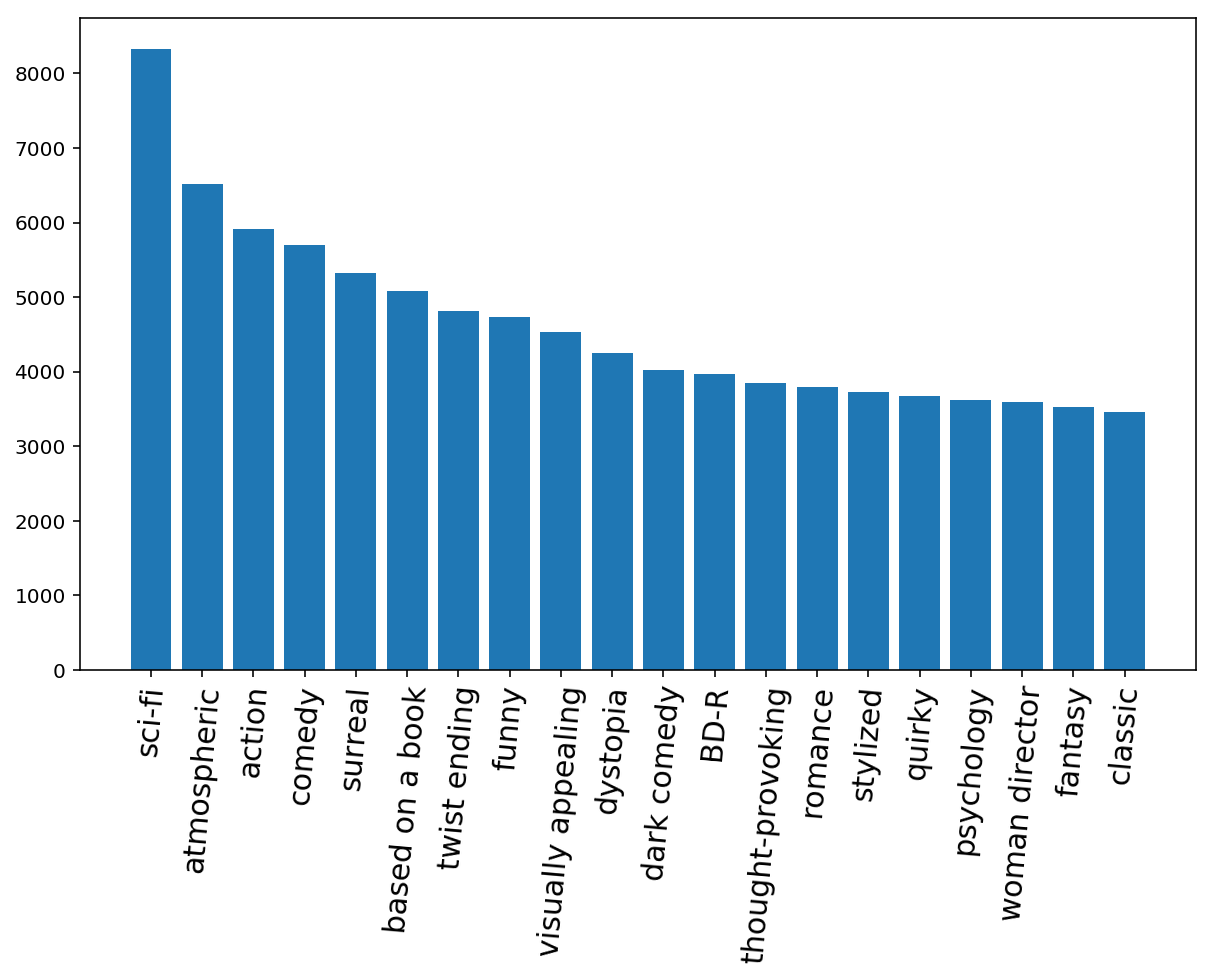

In [23]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [24]:
%%time
(
ratings
    .map(lambda r: (r.movie_id, 1))
    .reduceByKey(lambda a, b: a + b)
    .join(movies)
    .sortBy(lambda key_value: key_value[1][0], ascending=False)
    .map(lambda x: (x[1][1][1], x[1][0]))
    .take(10)
)

CPU times: user 26.6 ms, sys: 3.67 ms, total: 30.3 ms
Wall time: 17 s


[('Forrest Gump (1994)', 81491),
 ('"Shawshank Redemption', 81482),
 ('Pulp Fiction (1994)', 79672),
 ('"Silence of the Lambs', 74127),
 ('"Matrix', 72674),
 ('Star Wars: Episode IV - A New Hope (1977)', 68717),
 ('Jurassic Park (1993)', 64144),
 ("Schindler's List (1993)", 60411),
 ('Braveheart (1995)', 59184),
 ('Fight Club (1999)', 58773)]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [25]:
%%time
(
ratings
    .filter(lambda r: r.rating == 5)
    .map(lambda r: (r.movie_id, 1))
    .reduceByKey(lambda a, b: a + b)
    .join(movies)
    .sortBy(lambda key_value: key_value[1][0], ascending=False)
    .map(lambda x: (x[1][1][1], x[1][0]))
    .take(10)
)

CPU times: user 27.4 ms, sys: 3.42 ms, total: 30.8 ms
Wall time: 17.4 s


[('"Shawshank Redemption', 39553),
 ('Pulp Fiction (1994)', 32169),
 ('Forrest Gump (1994)', 25918),
 ('Star Wars: Episode IV - A New Hope (1977)', 25804),
 ('"Matrix', 25482),
 ("Schindler's List (1993)", 24853),
 ('"Silence of the Lambs', 24801),
 ('"Godfather', 24418),
 ('"Usual Suspects', 21585),
 ('Fight Club (1999)', 21486)]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

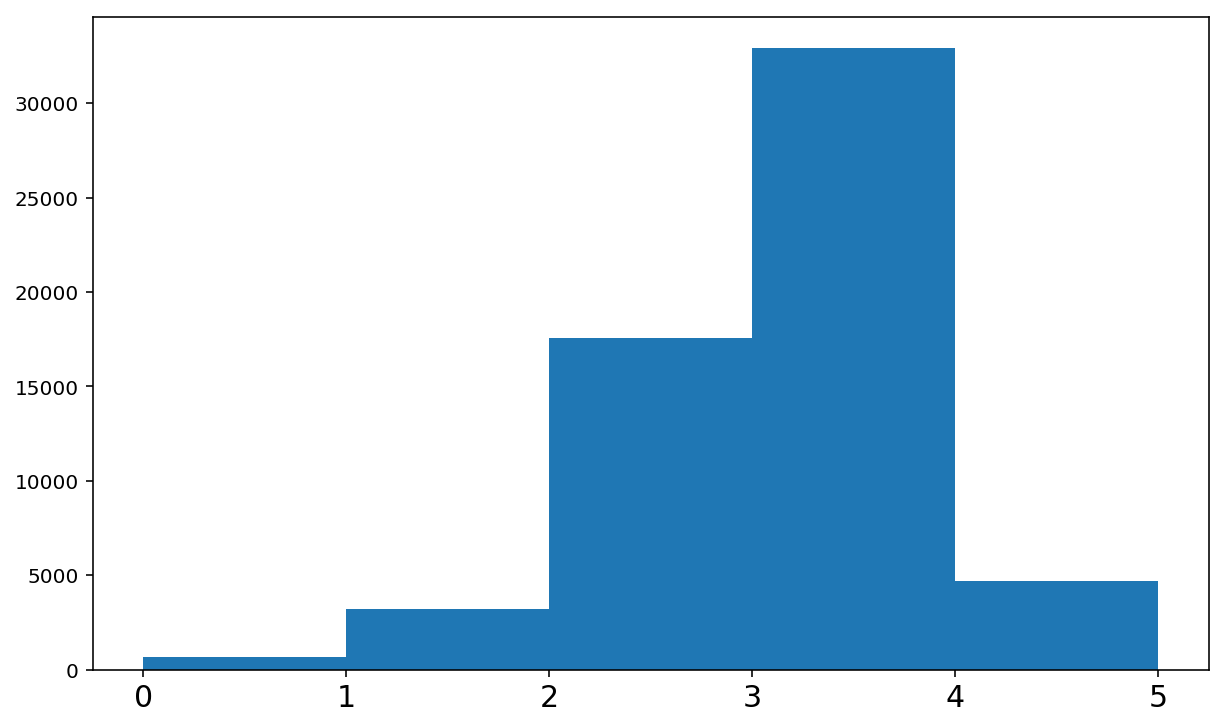

CPU times: user 341 ms, sys: 225 ms, total: 566 ms
Wall time: 368 ms


In [26]:
%%time

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(fontsize=15)
plt.hist(movie_avg_rating.map(lambda x: x[1]).collect(),
         bins=range(6))
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

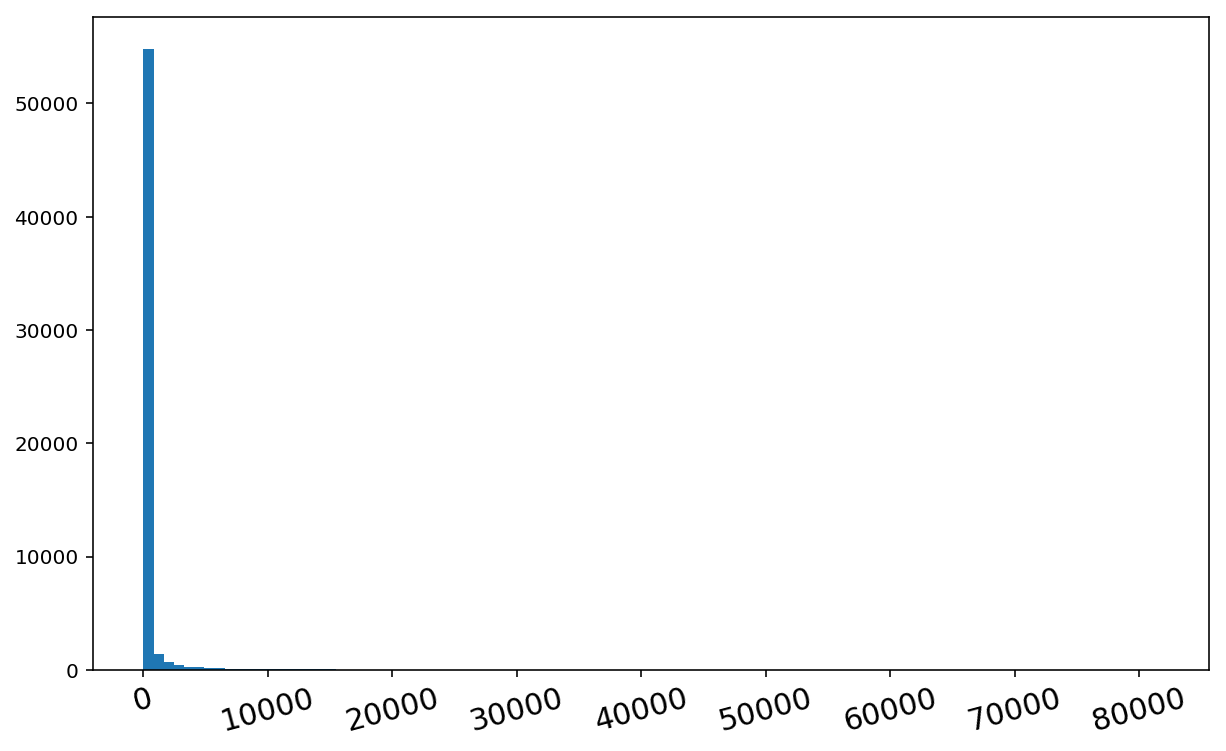

CPU times: user 487 ms, sys: 247 ms, total: 735 ms
Wall time: 19.5 s


In [27]:
%%time


f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=15, fontsize=15)
plt.hist(ratings.map(lambda r: (r.movie_id, 1)).reduceByKey(lambda a, b: a + b).map(lambda r: r[1]).collect(), bins=100)
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [28]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

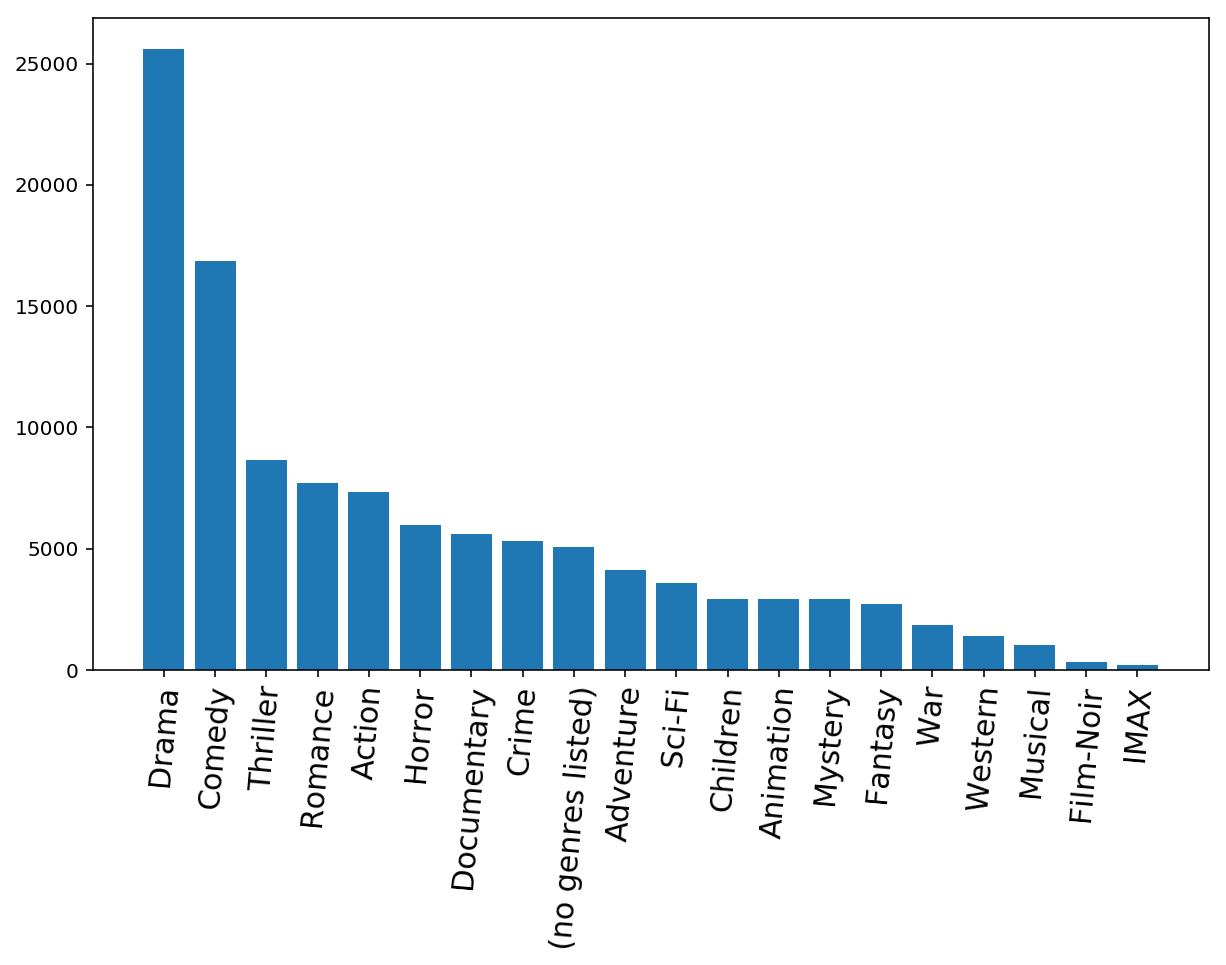

In [29]:
genres = (
    movies
        .filter(lambda x: x[0].isdigit())
        .map(lambda s: s.split(',')[-1])
        .flatMap(lambda x: x.split("|"))
        .map(lambda x: (x, 1))
        .reduceByKey(lambda a, b: a + b)
        .collect()
)

genres = sorted(genres, key=lambda cnt: cnt[1], reverse=True)

keys, values = zip(*genres)

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [30]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, "ratings.csv")
MOVIES_PATH = os.path.join(DATA_PATH, "movies.csv")
LINKS_PATH = os.path.join(DATA_PATH, "links.csv")
TMDB_PATH = os.path.join(DATA_PATH, "tmdb.json")

ratings = sc.textFile(RATINGS_PATH)
movies = sc.textFile(MOVIES_PATH)
links = sc.textFile(LINKS_PATH)
tmdb = sqlContext.read.json(TMDB_PATH).rdd

In [31]:
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [32]:
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

In [33]:
links.take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [34]:
id2tmdbid = (
    links
    .map(lambda x: x.split(","))
    .filter(lambda x: x[0].isdigit())
    .map(lambda x: (x[0], x[2]))
    .keyBy(lambda x: x[1])
    .map(lambda x: (x[0], x[1][0]))
)
id2tmdbid.take(5)

[('862', '1'), ('8844', '2'), ('15602', '3'), ('31357', '4'), ('11862', '5')]

In [35]:
(
tmdb
    .filter(lambda x: hasattr(x.casts, "cast") and 31 in [cst.id for cst in x.casts.cast])
    .map(lambda x: x.id)
    .keyBy(lambda x: str(x))
    .join(id2tmdbid)
    .map(lambda x: x[1][1])
    .keyBy(lambda x: int(x))
    .join(movies)
    .map(lambda x: x[1][1][1])
    .collect()
)


['Sleepless in Seattle (1993)',
 '"Celluloid Closet',
 'Elvis Has Left the Building (2004)',
 '"\'burbs',
 'Splash (1984)',
 'Every Time We Say Goodbye (1986)',
 '"League of Their Own',
 'Captain Phillips (2013)',
 'Toy Story of Terror (2013)',
 'Shooting War (2000)',
 'Killing Lincoln (2013)',
 'Toy Story (1995)',
 'And the Oscar Goes To... (2014)',
 'Bonfire of the Vanities (1990)',
 'Punchline (1988)',
 'Turner & Hooch (1989)',
 '"Simpsons Movie',
 'Larry Crowne (2011)',
 'Magnificent Desolation: Walking on the Moon (2005)',
 'Toy Story Toons: Small Fry (2011)',
 '"Man with One Red Shoe',
 'Toy Story 3 (2010)',
 'Sully (2016)',
 'Mazes and Monsters (1982)',
 'The Post (2017)',
 '"Money Pit',
 "You've Got Mail (1998)",
 'Toy Story 4 (2019)',
 'Radio Flyer (1992)',
 'California Typewriter (2017)',
 'Apollo 13 (1995)',
 '"Pixar Story',
 'Nothing in Common (1986)',
 'Angels & Demons (2009)',
 '"The Mayo Clinic',
 "He Knows You're Alone (a.k.a. Blood Wedding) (1980)",
 '"Ladykillers',
 '

In [36]:
(
tmdb
    .filter(lambda x: hasattr(x.casts, "cast"))
    .flatMap(lambda x: [act.name for act in x.casts.cast])
    .map(lambda x: (x, 1))
    .reduceByKey(lambda a, b: a + b)
    .sortBy(lambda x: x[1], ascending=False)
    .take(10)
)

[('Bess Flowers', 380),
 ('Frank Welker', 184),
 ('Christopher Lee', 175),
 ('Clarence Nash', 158),
 ('Irving Bacon', 152),
 ('John Carradine', 146),
 ('John Wayne', 142),
 ('Mel Blanc', 140),
 ('Samuel L. Jackson', 134),
 ('Eric Roberts', 133)]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [37]:
def cnt_gnr(row, unique_gnr):
    tmp = {g: 0 for g in unique_gnr}

    total = 0
    for gnr, cnt in row:
        tmp[gnr] = cnt
        total += cnt
        
    for gnr in tmp:
        tmp[gnr] /= total
      
    return list(tmp.values())
#     return tmp
        
    
#     out = [val / total for val in list(tmp.values())]
    
#     return (out, list(tmp.keys()))
#     return out

In [38]:
unique_gnr = (
    tmdb.filter(lambda x: x.genres)
    .flatMap(lambda x: [g.name for g in x.genres])
    .distinct()
    .collect()
)

In [39]:
unique_gnr

['Science Fiction',
 'Comedy',
 'Mystery',
 'Action',
 'Western',
 'Adventure',
 'Documentary',
 'Romance',
 'Fantasy',
 'Animation',
 'TV Movie',
 'Music',
 'Family',
 'Thriller',
 'Horror',
 'Crime',
 'Drama',
 'History',
 'War']

In [40]:
data = (
tmdb
    .filter(lambda x: x.genres)
    .flatMap(lambda x: [((x.release_date[:4], g.name), 1) for g in x.genres if x.release_date])
    .reduceByKey(lambda a, b: a + b)
    .map(lambda x: (x[0][0], (x[0][1], x[1])))
    .groupByKey()
    .mapValues(list)
    .sortBy(lambda x: x[0])
    .mapValues(lambda x: cnt_gnr(x, unique_gnr))
#     .collect()
)

In [41]:
data.take(10)

[('1874',
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('1878',
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('1881',
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('1883',
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('1887',
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('1888',
  [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.8,
   0.0,
   0.2,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0]),
 ('1890',
  [0.0

In [42]:
# y = data.map(lambda x: [v for v in x[1].values()]).collect()
# y  # 'Documentary', i.e. first '1', should be @ 6th pos


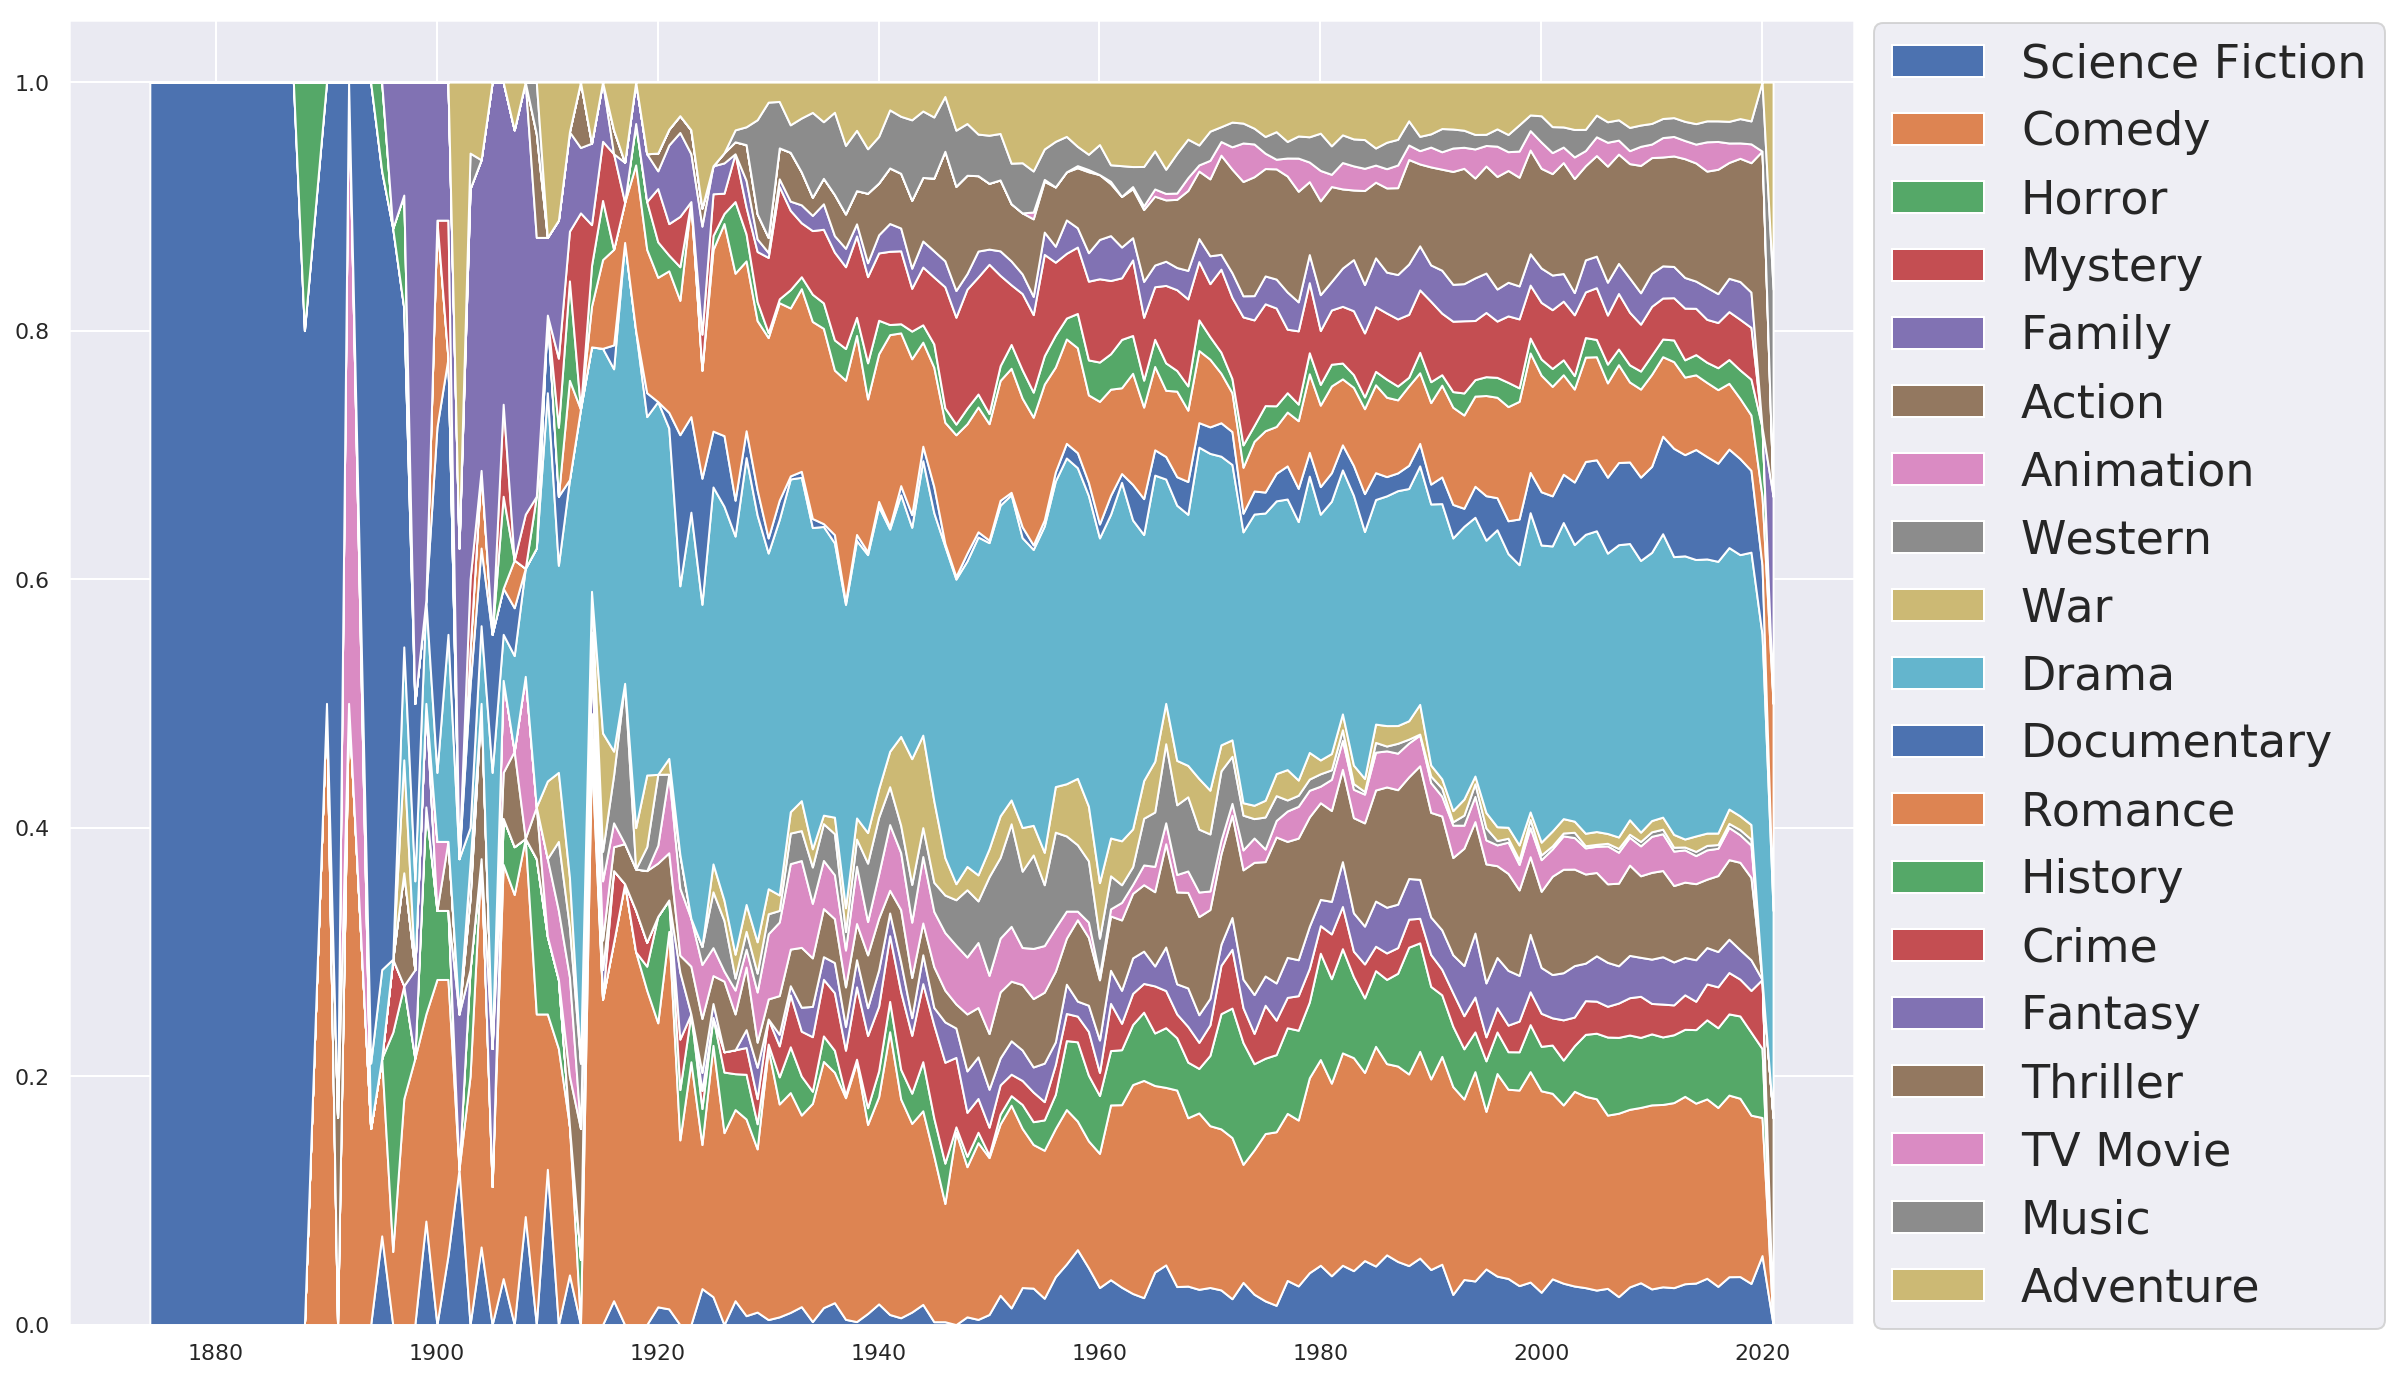

In [43]:
import numpy as np
import seaborn as sns
sns.set()

x = data.map(lambda x: int(x[0])).collect()
y = data.map(lambda x: x[1]).collect()

y = np.vstack(y).T

f, ax = plt.subplots(figsize=(16, 12))
labs = ['Science Fiction',
        'Comedy',
        'Horror',
        'Mystery',
        'Family',
        'Action',
        'Animation',
        'Western',
        'War',
        'Drama',
        'Documentary',
        'Romance',
        'History',
        'Crime',
        'Fantasy',
        'Thriller',
        'TV Movie',
        'Music',
        'Adventure']
plt.stackplot(x, y, labels=labs)
plt.legend(loc=1, bbox_to_anchor=(1.31, 1.015), fontsize=23)
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [44]:
######################################
######### YOUR CODE HERE #############
######################################